**by: Valeria Viridiana Pineda Romero**

# Time Series Clustering using the Google Mobility Report of Mexico

## Data Preprocessing

We performed data cleaning tasks initially, such as variable selection, data engineering, and handling missing data.

### Variable Selection

Firstly, we eliminated the variables: `iso_3166_2_code`, `sub_region_2`, `metro_area`, `census_fips_code`, and `country_region`. The variable `iso_3166_2_code` was eliminated to avoid multicollinearity as it repeated information from variable `sub_region_1`. The variable `sub_region_2` was deleted as it did not add valuable information about the observations. Finally, the variables `metro_area`, `census_fips_code`, and `country_region` were composed entirely of missing values; thus, these were also removed.

In [28]:
import pandas as pd
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error


In [29]:
series = pd.read_csv('2020_MX_Region_Mobility_Report.csv', header=0, index_col=0)
del series['sub_region_2'] # Same value for all instances
del series['metro_area'] # all missing data
del series['census_fips_code'] # all missing data
del series['country_region'] # all missing data
del series['iso_3166_2_code']

In [30]:
series.describe()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,9141.000000,9141.000000,9141.000000,8981.000000,9141.000000,9141.000000
mean,-35.836561,-11.942457,-33.865551,-36.808819,-24.892244,12.287605
std,17.883784,10.646250,17.450316,19.748865,18.604407,6.888538
min,-90.000000,-86.000000,-87.000000,-90.000000,-81.000000,-5.000000
25%,-48.000000,-18.000000,-45.000000,-50.000000,-38.000000,9.000000
50%,-35.000000,-11.000000,-36.000000,-39.000000,-29.000000,13.000000
75%,-28.000000,-5.000000,-27.000000,-28.000000,-10.000000,17.000000
max,23.000000,24.000000,61.000000,31.000000,22.000000,39.000000


In [31]:
series.describe(include=[object])

,sub_region_1,date
count,8864,9141
unique,32,277
top,Baja California,2020-06-07
freq,277,33


### Data Engineering

Next, we set the `date` variable as a DateTime data type, and we proceeded to place it as the index of the data frame.

In [32]:
series['date'] = pd.to_datetime(series['date']).dt.strftime('%d/%m/%Y')

In [33]:
series.set_index('date', inplace=True)

### Missing Data

Moreover, we analyzed the missing data, which appeared in `sub_region_1` and `transit_stations_percent_change_from_baseline` variables. Variable `sub_region_1` was made up of 3.03% of missing data. However, according to the information given, missing data in `sub_region_1` represent data at a national level. Thus, missing values were imputed with the `National Level` category. 

In [34]:
pd.DataFrame(series.isnull().sum()/len(series)*100,columns=["NA"])

,NA
sub_region_1,3.030303
retail_and_recreation_percent_change_from_baseline,0.000000
grocery_and_pharmacy_percent_change_from_baseline,0.000000
parks_percent_change_from_baseline,0.000000
transit_stations_percent_change_from_baseline,1.750356
workplaces_percent_change_from_baseline,0.000000
residential_percent_change_from_baseline,0.000000


Percent of Total Missing Values

In [35]:
len(series[series.isnull().any(axis=1)])/len(series)*100

4.78065857127229

Replace NA in 'sub_region_1' with 'National Level'

In [36]:
series['sub_region_1'] = series['sub_region_1'].fillna('National Level')

On the other hand, `transit_stations_percent_change_from_baseline` variable presents 1.75% of missing data. Hence, we proceeded to treat them. As a time series analysis, we could not eliminate the instances that present missing data, so we decided to interpolate them.

In [37]:
series['transit_stations_percent_change_from_baseline'] = series['transit_stations_percent_change_from_baseline'].interpolate()


Total Missing Values

In [38]:
len(series[series.isnull().any(axis=1)])/len(series)

0.0

## Modeling

For this stage we grouped the states to identify which of them follow a similar behavior in terms of mobility in workplaces. In this project we applied the Hierarchical Clustering with several methods: the Single Method with the Pearson Correlation, the Single Method with the Spearman Correlation, the Single Method with the Dynamic Time Warpping, and the Ward method with Euclidean distance. 

In [39]:
State = ['Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Coahuila',
 'Colima',
 'Durango',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Mexico City',
 'Michoacán',
 'Morelos',
 'Nayarit',
 'Nuevo Leon',
 'Oaxaca',
 'Puebla',
 'Querétaro',
 'Quintana Roo',
 'San Luis Potosi',
 'Sinaloa',
 'Sonora',
 'State of Mexico',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz',
 'Yucatan',
 'Zacatecas']

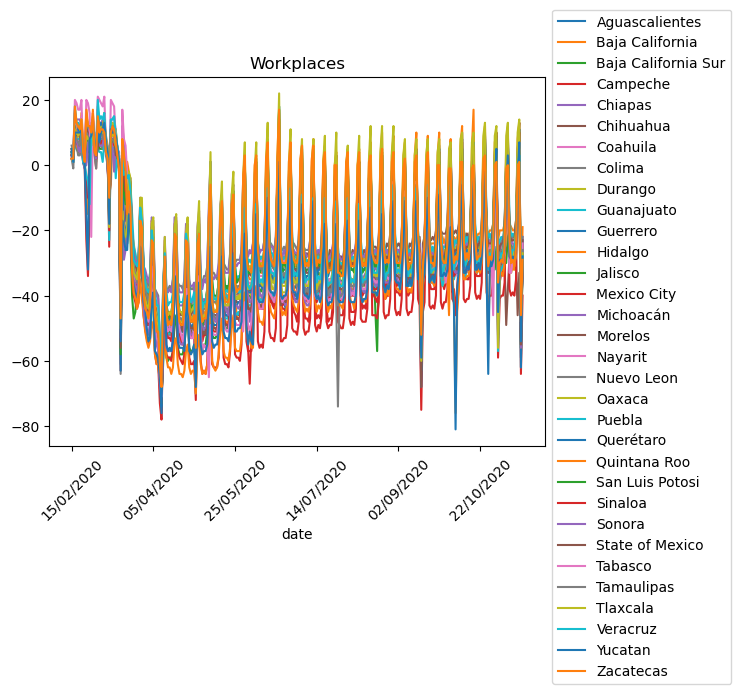

In [40]:
timeSeries = pd.DataFrame()
for i in State:
    data = series[series['sub_region_1']==i]
    data['workplaces_percent_change_from_baseline'].plot(label=i)
    timeSeries = timeSeries.append(data['workplaces_percent_change_from_baseline'])
pyplot.xticks(rotation=45)
pyplot.legend(bbox_to_anchor = (1, 1.2))
pyplot.title('Workplaces')
pyplot.show()
timeSeries.index = State

In [41]:
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram, linkage

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)
    
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### Ward's method

In [42]:
Z = hac.linkage(timeSeries, method='ward',optimal_ordering=True)

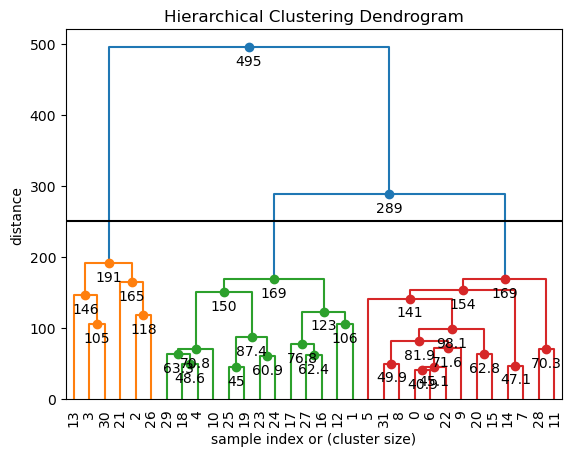

In [43]:
# set cut-off to 80
max_d = 250  # max_d as in max_distance

fancy_dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Pearson Correlation

In [44]:
# Clustering with Linkage
Z_pearson_correlation = hac.linkage(timeSeries, method='single', metric='correlation', optimal_ordering=True)

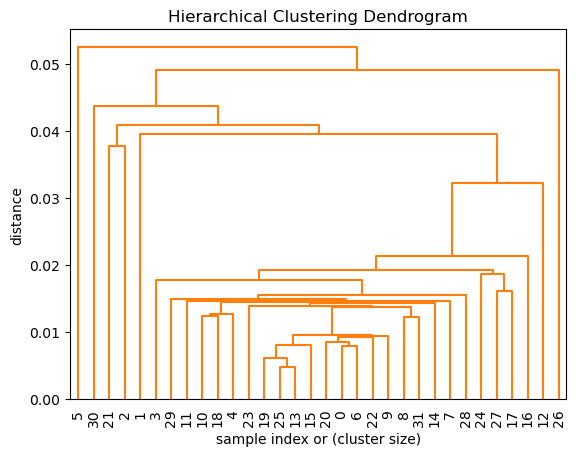

In [45]:
fancy_dendrogram(
    Z_pearson_correlation,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Spearman Correlation

In [46]:
# Here we use spearman correlation
def my_metric(x, y):
    r = stats.spearmanr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2 # IF THE CLUSTERS ARE THE SAME THE DISTANCE WILL BE 0

# Do the clustering    
Z_spearman_correlation = hac.linkage(timeSeries,  method='single', metric=my_metric, optimal_ordering=True)

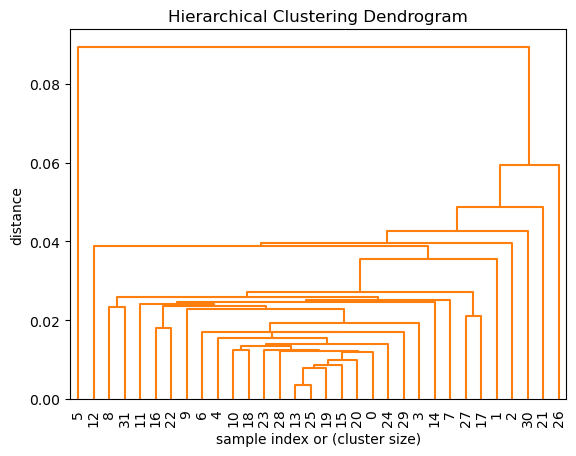

In [47]:
fancy_dendrogram(
    Z_spearman_correlation,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

### Dynamic Time Warpping

In [48]:
# Example of DTW
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Here we use dtw as distance metric
def dtw(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance

# Do the clustering with DTW
Z_dtw = hac.linkage(timeSeries,  method='single', metric=dtw, optimal_ordering=True)

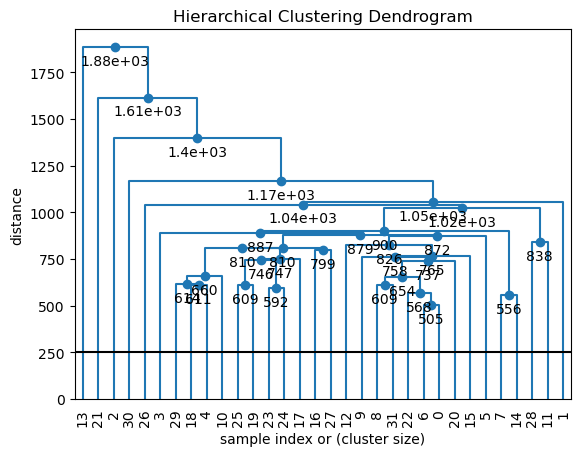

In [49]:
fancy_dendrogram(
    Z_dtw,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=max_d
)

plt.show()

The Ward method with Euclidean distance generates the most balanced clusters. This method, says that the distance between two clusters, A and B, is how much the sum of squares will increase when we merge them. Given its balanced results, we decided to group the States in such form.

## Deployment

### Generating clusters with Ward's method

The graphs below show the three clusters formed with the Ward method with Euclidean distance.

In [50]:
from scipy.cluster.hierarchy import fcluster


def print_clusters(ts, Z, k, plot=False):
    plt.figure(figsize=(5, 5))
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    print(results)

    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    
    new_order = series.index.unique()
    ts = ts.T.reindex(new_order, axis=0)

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            ts.iloc[:,cluster_indeces].plot()
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor = (1, 1))
        plt.show()

[3 2 1 1 2 3 3 3 3 3 2 3 2 1 3 3 2 2 2 2 3 1 3 2 2 2 1 2 3 2 1 3]
Cluster 3 number of entries 13


<Figure size 500x500 with 0 Axes>

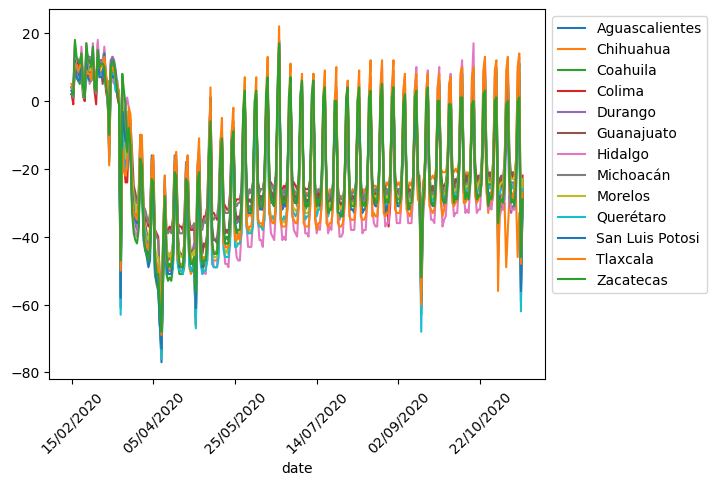

Cluster 2 number of entries 13


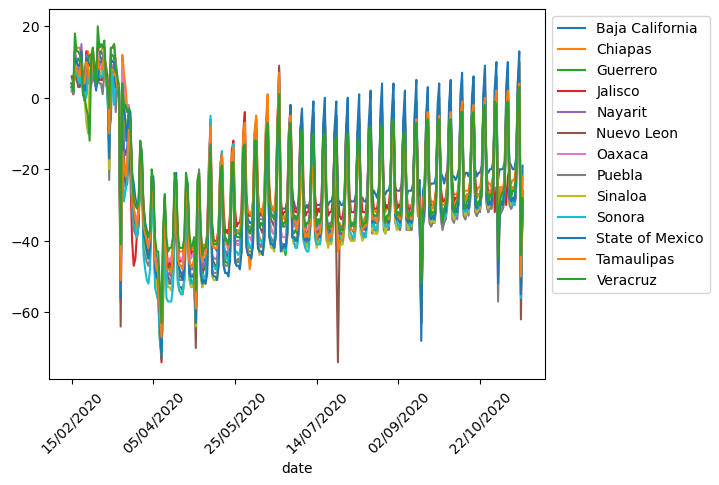

Cluster 1 number of entries 6


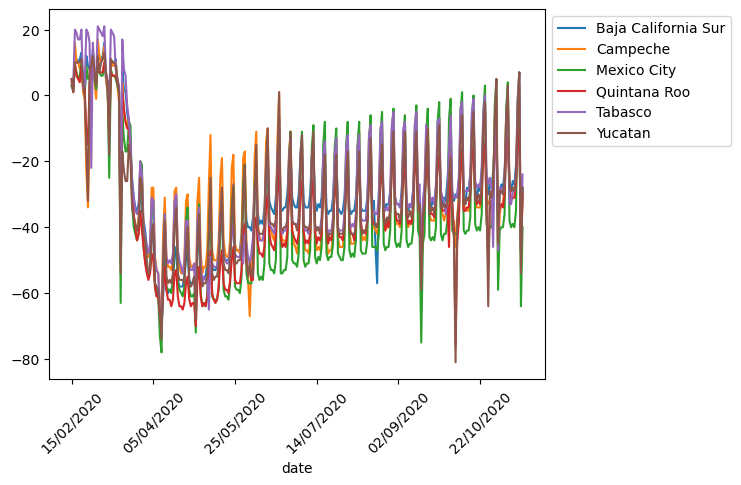

In [51]:
print_clusters(timeSeries, Z, 3, plot=True)